# Import Libraries

In [30]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop

# Load dataset

In [2]:
os.chdir("/content/drive/My Drive/BCML/titanic")

In [3]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [4]:
# Melakukan concat antara dataset training dan test
titanic_com = pd.concat([pd.read_csv(f) for f in all_filenames ])

titanic_com.to_csv( "titanic_com.csv", index=False, encoding='utf-8-sig')

In [9]:
dataset = pd.read_csv('titanic_com.csv')
dataset.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,0,male,54.0,0,0,51.8625,First,E,Southampton,y
2,1,female,58.0,0,0,26.5500,First,C,Southampton,y
3,1,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,1,male,34.0,0,0,13.0000,Second,D,Southampton,y


# Data Cleaning dan EDA

In [13]:
dataset.describe()

,survived,age,n_siblings_spouses,parch,fare
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,29.361582,0.523008,0.381594,32.204208
std,0.486592,13.019697,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


^ Berhasil dilakukan concat berdasarkan jumlah data pada dataset sekarang

In [14]:
# Mengacak data yang ada pada dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,20.0,0,0,7.8542,Third,unknown,Southampton,y
1,0,male,28.0,1,0,15.5000,Third,unknown,Queenstown,n
2,0,female,27.0,1,0,21.0000,Second,unknown,Southampton,n
3,0,male,36.0,0,0,10.5000,Second,unknown,Southampton,y
4,0,male,38.0,0,0,8.6625,Third,unknown,Southampton,y


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            891 non-null    int64  
 1   sex                 891 non-null    object 
 2   age                 891 non-null    float64
 3   n_siblings_spouses  891 non-null    int64  
 4   parch               891 non-null    int64  
 5   fare                891 non-null    float64
 6   class               891 non-null    object 
 7   deck                891 non-null    object 
 8   embark_town         891 non-null    object 
 9   alone               891 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 69.7+ KB


In [16]:
# Mengantisipasi data '?' dengan mereplace value tersebut dengan null
dataset.replace("?", np.nan, inplace=True)

In [17]:
dataset.isnull().sum().sort_values()

survived              0
sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64

In [21]:
# EDA terhadap data untuk melihat berapa jenis value pada kolom tersebut
# dataset['deck'].value_counts()
dataset['class'].value_counts()

Third     491
First     216
Second    184
Name: class, dtype: int64

In [22]:
# Drop kolom yang kurang berkaitan dengan label survived
dataset.drop(['embark_town', 'fare'], axis=1, inplace=True)
dataset.head()

,survived,sex,age,n_siblings_spouses,parch,class,deck,alone
0,0,male,20.0,0,0,Third,unknown,y
1,0,male,28.0,1,0,Third,unknown,n
2,0,female,27.0,1,0,Second,unknown,n
3,0,male,36.0,0,0,Second,unknown,y
4,0,male,38.0,0,0,Third,unknown,y


In [23]:
# Melakukan one-hot encoding terhadap data string
sex_categorized = pd.get_dummies(dataset['sex'])
deck_categorized = pd.get_dummies(dataset['deck'])
alone_categorized = pd.get_dummies(dataset['alone'])

dataset = pd.concat([dataset, sex_categorized], axis=1)
dataset = pd.concat([dataset, deck_categorized], axis=1)
dataset = pd.concat([dataset, alone_categorized], axis=1)

dataset.head()

,survived,sex,age,n_siblings_spouses,parch,class,deck,alone,female,male,A,B,C,D,E,F,G,unknown,n,y
0,0,male,20.0,0,0,Third,unknown,y,0,1,0,0,0,0,0,0,0,1,0,1
1,0,male,28.0,1,0,Third,unknown,n,0,1,0,0,0,0,0,0,0,1,1,0
2,0,female,27.0,1,0,Second,unknown,n,1,0,0,0,0,0,0,0,0,1,1,0
3,0,male,36.0,0,0,Second,unknown,y,0,1,0,0,0,0,0,0,0,1,0,1
4,0,male,38.0,0,0,Third,unknown,y,0,1,0,0,0,0,0,0,0,1,0,1


In [25]:
# Melakukan label encoding terhadap feature 'class' karena data seperti suatu tingkatan
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
dataset['class_cat'] = labelencoder.fit_transform(dataset['class'])
dataset.head()

,survived,sex,age,n_siblings_spouses,parch,class,deck,alone,female,male,A,B,C,D,E,F,G,unknown,n,y,class_cat
0,0,male,20.0,0,0,Third,unknown,y,0,1,0,0,0,0,0,0,0,1,0,1,2
1,0,male,28.0,1,0,Third,unknown,n,0,1,0,0,0,0,0,0,0,1,1,0,2
2,0,female,27.0,1,0,Second,unknown,n,1,0,0,0,0,0,0,0,0,1,1,0,1
3,0,male,36.0,0,0,Second,unknown,y,0,1,0,0,0,0,0,0,0,1,0,1,1
4,0,male,38.0,0,0,Third,unknown,y,0,1,0,0,0,0,0,0,0,1,0,1,2


In [26]:
# Drop kolom-kolom string
dataset.drop(['sex', 'class', 'deck', 'alone'], axis=1, inplace=True)
dataset.head()

,survived,age,n_siblings_spouses,parch,female,male,A,B,C,D,E,F,G,unknown,n,y,class_cat
0,0,20.0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,2
1,0,28.0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,2
2,0,27.0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,1
3,0,36.0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1
4,0,38.0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,2


In [27]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            891 non-null    int64  
 1   age                 891 non-null    float64
 2   n_siblings_spouses  891 non-null    int64  
 3   parch               891 non-null    int64  
 4   female              891 non-null    uint8  
 5   male                891 non-null    uint8  
 6   A                   891 non-null    uint8  
 7   B                   891 non-null    uint8  
 8   C                   891 non-null    uint8  
 9   D                   891 non-null    uint8  
 10  E                   891 non-null    uint8  
 11  F                   891 non-null    uint8  
 12  G                   891 non-null    uint8  
 13  unknown             891 non-null    uint8  
 14  n                   891 non-null    uint8  
 15  y                   891 non-null    uint8  
 16  class_ca

# Feature Engineering

In [78]:
feature = dataset.drop(['survived'], axis=1)
label = dataset['survived']

# Scaling data dengan Power Transformer(yeo-johnson)
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
scaler = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)

feature_scaled = scaler.fit_transform(feature.values)

# Split data 75:15

from sklearn.model_selection import train_test_split
feature_train, feature_test, label_train, label_test = train_test_split(feature_scaled, label, test_size=0.15, random_state=10)

# Modeling

In [79]:
# Menggunakan 1 hidden layer yang lebar(3096 Neuron), activation relu dan output sigmoid
model = Sequential()
model.add(Dense(3096, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid')) # Output 2 class

opt = SGD(learning_rate=0.0001, momentum=0.9)
# Loss fuction menggunakan binary karena hanya 2 class(Survived/tidak), Optimizer SGD
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Batch size 8 dengan epoch 50
history = model.fit(x=feature_train, y=label_train, validation_data=(feature_test, label_test), epochs=40, batch_size=8)
model.summary()

Epoch 1/40
95/95 [==============================] - 0s 2ms/step - loss: 0.5321 - accuracy: 0.7266 - val_loss: 0.3981 - val_accuracy: 0.8507
Epoch 2/40
95/95 [==============================] - 0s 1ms/step - loss: 0.4496 - accuracy: 0.8124 - val_loss: 0.4093 - val_accuracy: 0.8284
Epoch 3/40
95/95 [==============================] - 0s 1ms/step - loss: 0.4351 - accuracy: 0.8269 - val_loss: 0.3889 - val_accuracy: 0.8433
Epoch 4/40
95/95 [==============================] - 0s 1ms/step - loss: 0.4338 - accuracy: 0.8137 - val_loss: 0.3974 - val_accuracy: 0.8284
Epoch 5/40
95/95 [==============================] - 0s 1ms/step - loss: 0.4266 - accuracy: 0.8230 - val_loss: 0.3952 - val_accuracy: 0.8358
Epoch 6/40
95/95 [==============================] - 0s 1ms/step - loss: 0.4274 - accuracy: 0.8217 - val_loss: 0.4106 - val_accuracy: 0.8209
Epoch 7/40
95/95 [==============================] - 0s 1ms/step - loss: 0.4246 - accuracy: 0.8362 - val_loss: 0.3878 - val_accuracy: 0.8582
Epoch 8/40
95/95 [==

In [80]:
# Function untuk plot history
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

In [81]:
# Menampilkan val_loss terkecil dengan dataframe
history_dataframe = pd.DataFrame(history.history)
history_dataframe['epoch'] = history.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,accuracy,val_loss,val_accuracy,epoch
6,0.424601,0.836196,0.387803,0.858209,6
2,0.435073,0.826948,0.388869,0.843284,2
12,0.413608,0.836196,0.391725,0.850746,12
13,0.418824,0.828269,0.393600,0.820895,13
15,0.412394,0.830912,0.394740,0.843284,15
4,0.426619,0.822985,0.395173,0.835821,4
3,0.433768,0.813738,0.397424,0.828358,3
0,0.532142,0.726552,0.398065,0.850746,0
30,0.401843,0.837516,0.398676,0.843284,30
8,0.428336,0.826948,0.398866,0.820895,8


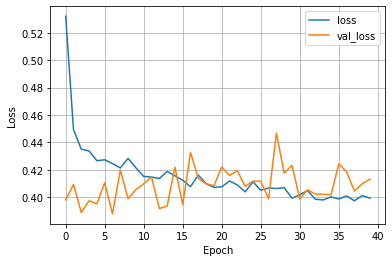

In [82]:
plot_loss(history)

# Hasil

Dari sorting value dataframe didapat val_loss terendah adalah pada epoch 6, dan sejalan dengan yang ditampilkan pada plot history dimana titik terendah mengarah pada epoch 6

Epoch : 6

Loss : 	0.424601

Accuracy : 0.836196

Val_Loss : 0.387803

Val_Accuracy : 0.858209